In [1]:
# Install  libraries
!pip install seaborn joblib

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
from google.colab import files
uploaded = files.upload()# file upload from local system


Saving (cleaned)NYC_restaurant_insp_result.csv to (cleaned)NYC_restaurant_insp_result (1).csv


In [5]:
def analyze_class_distribution(df):
    """Analyze and visualize class distribution"""
    print("Class Distribution Analysis:")
    print("=" * 50)

    grade_counts = df['GRADE'].value_counts()
    grade_percentages = df['GRADE'].value_counts(normalize=True) * 100

    distribution_df = pd.DataFrame({
        'Count': grade_counts,
        'Percentage': grade_percentages
    })

    print(distribution_df)
    print("\n")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='GRADE', order=grade_counts.index)
    plt.title('Distribution of Restaurant Grades', fontsize=16)
    plt.xlabel('Grade', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    for i, count in enumerate(grade_counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('grade_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return grade_counts


Starting balanced model training with class imbalance analysis...
Data loaded successfully. Shape: (103426, 26)
Class Distribution Analysis:
       Count  Percentage
GRADE                   
A      68421   70.987187
B       9972   10.346008
N       7058    7.322716
C       5210    5.405405
Z       5167    5.360793
P        557    0.577891




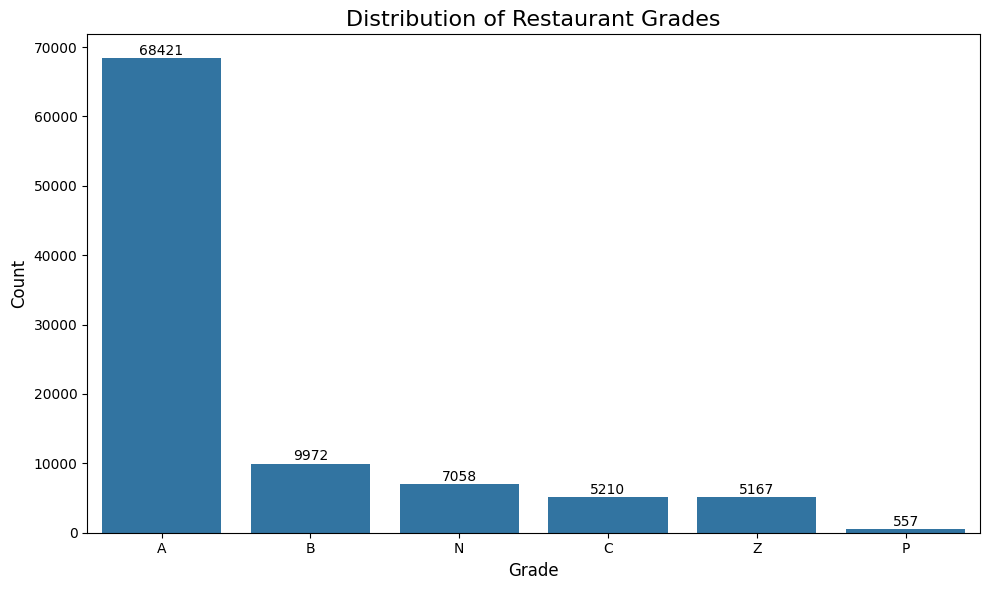

Grade mapping: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'N': np.int64(3), 'P': np.int64(4), 'Z': np.int64(5)}

Class Weights:
A: 0.2348
B: 1.6110
C: 3.0833
N: 2.2762
P: 28.8146
Z: 3.1087

STANDARD MODEL:
Accuracy: 0.9552, Macro F1-Score: 0.7842
              precision    recall  f1-score   support

           A       0.99      1.00      0.99     13684
           B       0.87      0.97      0.92      1995
           C       0.83      0.85      0.84      1042
           N       0.99      0.93      0.96      1412
           P       0.62      0.25      0.36       111
           Z       0.74      0.55      0.63      1033

    accuracy                           0.96     19277
   macro avg       0.84      0.76      0.78     19277
weighted avg       0.95      0.96      0.95     19277


WEIGHTED MODEL:
Accuracy: 0.9581, Macro F1-Score: 0.8436
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     13684
           B       0.93      0.

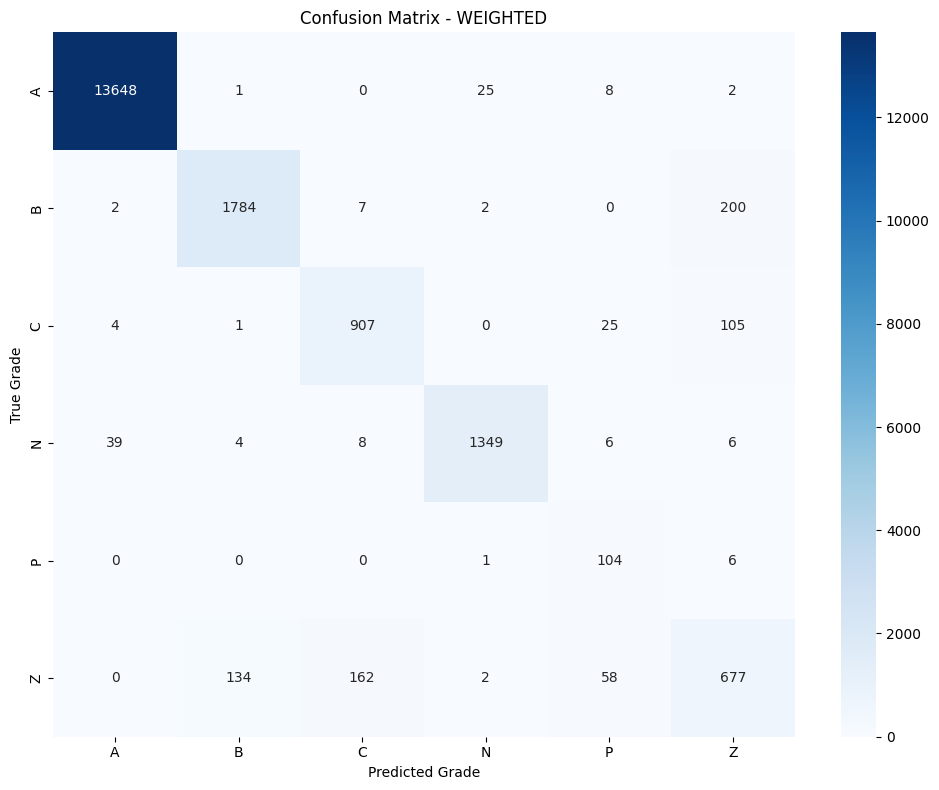


🎉 Model saved as 'random_forest_model.sav'
📂 Cleaned dataset saved as 'cleaned_restaurant_data.csv'


In [6]:
def train_and_save_model():
    print("Starting balanced model training with class imbalance analysis...")

    # Load dataset (uploaded in Colab)
    try:
        data = pd.read_csv("/content/(cleaned)NYC_restaurant_insp_result.csv")
        print(f"Data loaded successfully. Shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return False

    # Preprocessing
    df = data.copy()
    df['GRADE'] = df['GRADE'].fillna('Not Graded')
    df = df[df['GRADE'].isin(['A', 'B', 'C', 'N', 'Z', 'P'])]

    grade_counts = analyze_class_distribution(df)
    min_samples_threshold = 50
    rare_classes = grade_counts[grade_counts < min_samples_threshold].index.tolist()
    if rare_classes:
        print(f"⚠️ Rare classes (<{min_samples_threshold} samples): {rare_classes}")

    df['INSPECTION TYPE'] = df['INSPECTION TYPE'].fillna('Unknown')
    df['CRITICAL FLAG'] = df['CRITICAL FLAG'].fillna('Not Applicable')
    df['VIOLATION CODE'] = df['VIOLATION CODE'].fillna('No Violation')
    df['SCORE'] = df['SCORE'].fillna(df['SCORE'].median())

    df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'], errors='coerce')
    df['inspection_year'] = df['INSPECTION DATE'].dt.year
    df['inspection_month'] = df['INSPECTION DATE'].dt.month
    df['inspection_day_of_week'] = df['INSPECTION DATE'].dt.dayofweek

    df = df.dropna(subset=['GRADE'])

    features = ['INSPECTION TYPE', 'CRITICAL FLAG', 'VIOLATION CODE', 'SCORE',
                'inspection_year', 'inspection_month', 'inspection_day_of_week']
    model_df = df[features + ['GRADE']].copy()

    # Encode categorical
    label_encoders = {}
    categorical_features = ['INSPECTION TYPE', 'CRITICAL FLAG', 'VIOLATION CODE']
    for feature in categorical_features:
        le = LabelEncoder()
        model_df[feature] = le.fit_transform(model_df[feature].astype(str))
        label_encoders[feature] = le

    grade_encoder = LabelEncoder()
    model_df['GRADE_encoded'] = grade_encoder.fit_transform(model_df['GRADE'])
    label_encoders['GRADE'] = grade_encoder
    grade_mapping = dict(zip(grade_encoder.classes_, grade_encoder.transform(grade_encoder.classes_)))
    print("Grade mapping:", grade_mapping)

    X = model_df.drop(['GRADE', 'GRADE_encoded'], axis=1)
    y = model_df['GRADE_encoded']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    print("\nClass Weights:")
    for grade_encoded, weight in class_weight_dict.items():
        grade_name = grade_encoder.inverse_transform([grade_encoded])[0]
        print(f"{grade_name}: {weight:.4f}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Models
    models = {}
    rf_standard = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf_standard.fit(X_train_scaled, y_train)
    models['standard'] = rf_standard

    rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10,
                                         class_weight=class_weight_dict)
    rf_weighted.fit(X_train_scaled, y_train)
    models['weighted'] = rf_weighted

    rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10,
                                         class_weight='balanced_subsample')
    rf_balanced.fit(X_train_scaled, y_train)
    models['balanced_subsample'] = rf_balanced

    # Evaluate
    best_model = None
    best_f1_score = 0
    best_model_name = ""
    for name, model in models.items():
        print(f"\n{name.upper()} MODEL:")
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=grade_encoder.classes_, output_dict=True)
        macro_f1 = report['macro avg']['f1-score']
        print(f"Accuracy: {accuracy:.4f}, Macro F1-Score: {macro_f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=grade_encoder.classes_))

        if macro_f1 > best_f1_score:
            best_f1_score = macro_f1
            best_model = model
            best_model_name = name

    print(f"\n✅ BEST MODEL: {best_model_name.upper()} (F1: {best_f1_score:.4f})")

    # Confusion Matrix
    y_pred_best = best_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=grade_encoder.classes_,
                yticklabels=grade_encoder.classes_)
    plt.title(f'Confusion Matrix - {best_model_name.upper()}')
    plt.xlabel('Predicted Grade')
    plt.ylabel('True Grade')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save model
    model_objects = {
        'model': best_model,
        'model_type': best_model_name,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'features': features,
        'grade_encoder': grade_encoder,
        'grade_classes': grade_encoder.classes_,
        'class_weights': class_weight_dict
    }

    joblib.dump(model_objects, 'random_forest_model.sav')
    print("\n🎉 Model saved as 'random_forest_model.sav'")

    # Save cleaned dataset
    df.to_csv("cleaned_restaurant_data.csv", index=False)
    print("📂 Cleaned dataset saved as 'cleaned_restaurant_data.csv'")

    return True

# Run training
success = train_and_save_model()


In [7]:
from google.colab import files

files.download("random_forest_model.sav")
files.download("cleaned_restaurant_data.csv")
files.download("confusion_matrix.png")
files.download("grade_distribution.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>